# Model Analysis and Testing

In [26]:
#!pip install plotly gower dateutil kmodes scikit-learn

In [90]:
import os
import ast
import tempfile

import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, BaggingClassifier
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, PrecisionRecallDisplay
from scipy.cluster.hierarchy import linkage, fcluster
import gower

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
# Settings for plot rendering, makes work with HTML output + jupyer lab + static output
pio.renderers.default = "notebook+plotly_mimetype+png"
# pio.renderers.default = "png"
%matplotlib inline

## Load and format data

In [2]:
# Use normpath to make work on windows machines
data_dir = os.path.normpath("../data/")
eedi_dir = os.path.join(data_dir, "Eedi_dataset")
eedi_metadata_dir = os.path.join(eedi_dir, "metadata")

df_train = pd.read_csv(os.path.join(eedi_dir, "train_data", "train_task_3_4.csv"))
df_answer = pd.read_csv(os.path.join(eedi_metadata_dir, "answer_metadata_task_3_4.csv"), parse_dates=["DateAnswered"])
df_student = pd.read_csv(os.path.join(eedi_metadata_dir, "student_metadata_task_3_4.csv"), parse_dates=["DateOfBirth"])
df_question = pd.read_csv(os.path.join(eedi_metadata_dir, "question_metadata_task_3_4.csv"))
df_subject = pd.read_csv(os.path.join(eedi_metadata_dir, "subject_metadata.csv"))

# Join the datasets on the relevant keys, so that we only have to work with two DFs: df_total and df_subject
df_total = df_train.join(df_answer.set_index('AnswerId'), on="AnswerId")\
                    .join(df_student.set_index("UserId"), on="UserId")\
                    .join(df_question.set_index("QuestionId"), on="QuestionId")

# Convert str col to proper dtype, list of ints
df_total.SubjectId = df_total.SubjectId.apply(ast.literal_eval)
# Convert PremiumPupil to proper dtype of bool
df_total.PremiumPupil = df_total.PremiumPupil.fillna(0).astype(bool)
# Make age column and drop DateOfBirth
df_total["Age"] = df_total.apply(lambda x: relativedelta(x.DateAnswered, x.DateOfBirth).years if not pd.isnull(x.DateOfBirth) else np.NaN, axis=1) 
df_total = df_total.drop(columns=["DateOfBirth"])

subject_mapping = pd.Series(df_subject.Name.values,index=df_subject.SubjectId).to_dict()
# Make 1st level category ID
df_total["Category1"] = df_total.SubjectId.apply(lambda x: subject_mapping[x[1]])
# Make column with strs of the parentId
df_subject["ParentName"] = df_subject.ParentId.map(subject_mapping)


print(df_subject)
df_total

     SubjectId                       Name  ParentId  Level  \
0            3                      Maths       NaN      0   
1           32                     Number       3.0      1   
2           33                     BIDMAS     144.0      3   
3           34     Upper and Lower Bounds     141.0      3   
4           35             Calculator Use      32.0      2   
..         ...                        ...       ...    ...   
383       1982  Mixed operation Fractions      39.0      3   
384       1983               Drawing Axes      54.0      3   
385       1985             Reading Scales      98.0      3   
386       1987             Sorting Shapes     174.0      3   
387       1988           Labelling Shapes     174.0      3   

                            ParentName  
0                                  NaN  
1                                Maths  
2                     Basic Arithmetic  
3              Rounding and Estimating  
4                               Number  
..       

,QuestionId,UserId,AnswerId,IsCorrect,CorrectAnswer,AnswerValue,DateAnswered,Confidence,GroupId,QuizId,SchemeOfWorkId,Gender,PremiumPupil,SubjectId,Age,Category1
0,898,2111,280203,1,2,2,2019-12-08 17:47:00,NaN,95,86,52562.0,2,False,"[3, 49, 62, 70]",12.0,Algebra
1,767,3062,55638,1,3,3,2019-10-27 20:54:00,25.0,115,39,52562.0,0,False,"[3, 32, 144, 204]",NaN,Number
2,165,1156,386475,1,2,2,2019-10-06 20:16:00,NaN,101,39,52562.0,0,False,"[3, 32, 37, 220]",NaN,Number
3,490,1653,997498,1,4,4,2020-02-27 17:40:00,NaN,46,115,52562.0,0,False,"[3, 49, 81, 406]",NaN,Algebra
4,298,3912,578636,1,3,3,2019-12-27 16:07:00,NaN,314,78,52562.0,2,False,"[3, 71, 74, 180]",11.0,Geometry and Measure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382722,80,2608,57945,1,2,2,2019-11-28 15:22:00,NaN,270,65,52562.0,0,False,"[3, 32, 42, 211]",NaN,Number
1382723,707,2549,584230,0,2,1,2020-01-06 16:26:00,NaN,269,109,52562.0,2,False,"[3, 32, 42, 212]",12.0,Number
1382724,840,5901,1138956,1,1,1,2020-01-07 07:14:00,NaN,270,66,52562.0,0,False,"[3, 32, 37, 219]",NaN,Number
1382725,794,3854,1151183,0,1,3,2019-12-15 16:32:00,NaN,339,9,52562.0,0,False,"[3, 49, 62, 70]",NaN,Algebra


## Clustering

Want to cluster over numerical AND categorical variables. 

* Use kmodes/kprototype [link](https://pypi.org/project/kmodes/)
* Use gower distance: [with hier clustering](http://webcache.googleusercontent.com/search?q=cache:https://towardsdatascience.com/clustering-on-numerical-and-categorical-features-6e0ebcf1cbad&strip=0&vwsrc=1&referer=medium-parser)
    * [another link w Rand index](https://www.kaggle.com/code/halflingwizard/clustering-categorical-data-using-gower-distance/notebook)

In [29]:
# cat_cols = ["QuestionId", "UserId", "IsCorrect", "DateAnswered", "Confidence", "GroupId", "QuizId", "Gender", "PremiumPupil", "Age"]
# df_cluster = df_total[]

### Clustering using the KPrototypes Algorithm

In [30]:
cat_cols = ["QuestionId", "UserId", "GroupId", "QuizId", "Gender", "IsCorrect", "PremiumPupil", "Age"]
cluster_cols = cat_cols + ["DateAnswered", "Confidence"]

df_cluster = df_total[cluster_cols].sample(frac=0.1, random_state=42).fillna(0)
df_cluster.DateAnswered = df_cluster.DateAnswered.dt.strftime("%Y%m%d").astype(int)

kprot = KPrototypes(n_clusters=3)
df_cluster["Clusters"]  = kprot.fit_predict(df_cluster, categorical=list(range(len(cat_cols))))
kprot

KPrototypes(gamma=1146.7452122828936, n_clusters=3)

In [31]:
df_cluster

,QuestionId,UserId,GroupId,QuizId,Gender,IsCorrect,PremiumPupil,Age,DateAnswered,Confidence,Clusters
379087,207,6032,104,78,1,1,False,11.0,20200102,0.0,0
1026777,130,2956,153,55,2,1,False,0.0,20200304,0.0,1
1347837,20,4471,275,105,0,1,False,0.0,20200210,0.0,0
630173,868,4602,118,9,0,0,False,0.0,20200116,0.0,0
363588,238,98,123,62,0,1,False,0.0,20200428,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
882524,735,1703,332,39,0,1,False,0.0,20191012,0.0,2
1020633,445,3391,166,9,2,0,False,12.0,20200104,100.0,0
1366835,281,2851,14,25,1,1,False,11.0,20191217,0.0,2
467562,625,5850,260,111,1,1,False,11.0,20200115,0.0,0


In [32]:
df_total["Clusters_K"] = np.NaN
df_total.loc[df_cluster.index, "Clusters_K"] = df_cluster["Clusters"]

# df_total.loc[df_cluster.index, "Clusters_K"]
df_total.Clusters_K.value_counts()

Clusters_K
2.0    73301
0.0    41230
1.0    23742
Name: count, dtype: int64

### Clustering using the Gower distance matrix

Gower Similarity is computed as the average of partial similarities (ps) across the m features of the observation, and can be used to calculate non-euclidian (aka more correct) distances between categorical features. 

In [34]:
# cat_cols = ["QuestionId", "UserId", "GroupId", "QuizId", "Gender", "IsCorrect", "PremiumPupil", "Age"]
# cluster_cols = cat_cols + ["DateAnswered", "Confidence"]

# df_cluster = df_total[cluster_cols].sample(frac=0.1, random_state=42).fillna(0)
# df_cluster.DateAnswered = df_cluster.DateAnswered.dt.strftime("%Y%m%d").astype(int)

gower_dists = gower.gower_matrix(df_cluster, cat_features = [True] * len(cat_cols) + [False] * (len(cluster_cols) - len(cat_cols)))

gower_dists

array([[0.        , 0.6021055 , 0.6011257 , ..., 0.4926117 , 0.40013552,
        0.40003127],
       [0.6021055 , 0.        , 0.5009798 , ..., 0.6947172 , 0.60197   ,
        0.60207427],
       [0.6011257 , 0.5009798 , 0.        , ..., 0.69373745, 0.60099024,
        0.6010945 ],
       ...,
       [0.4926117 , 0.6947172 , 0.69373745, ..., 0.        , 0.49274722,
        0.49264297],
       [0.40013552, 0.60197   , 0.60099024, ..., 0.49274722, 0.        ,
        0.40010422],
       [0.40003127, 0.60207427, 0.6010945 , ..., 0.49264297, 0.40010422,
        0.        ]], dtype=float32)

#### Gower with scipy fcluster

In [35]:
cluster_linkages = linkage(gower_dists) 
clusters = fcluster(cluster_linkages, t=3, criterion='maxclust')

clusters

MemoryError: Unable to allocate 142. GiB for an array with shape (138273, 138273) and data type float64

#### Gower with sklearn AgglomerativeClustering

In [38]:
# Memory of computing ~100K clustering too much, need to provide temp dir
with tempfile.TemporaryDirectory() as dir:
    model_single = AgglomerativeClustering(n_clusters=3, linkage='single', metric='precomputed', memory=dir)
    clusters_lsingle = model_single.fit_predict(gower_dists)
clusters_lsingle

MemoryError: Unable to allocate 17.8 GiB for an array with shape (138273, 138273) and data type bool

In [66]:
df_total[["QuestionId", "UserId"]].value_counts()

df_total[(df_total["QuestionId"] == 626) & (df_total["UserId"] == 4508)]

df_total["QuestionId"].value_counts(normalize=True)
# pd.DataFrame(df_total[cluster_cols].drop(columns="DateAnswered").value_counts(dropna=False)).reset_index()

QuestionId
199    0.002145
911    0.002137
89     0.002132
855    0.002130
764    0.002127
         ...   
832    0.000003
606    0.000003
153    0.000003
810    0.000003
603    0.000003
Name: proportion, Length: 948, dtype: float64

### Save clustering values

In [39]:
df_cluster["Clusters_K"] = df_total.loc[df_cluster.index, "Clusters_K"]
# df_cluster["Clusters_l_s"] = clusters_lsingle
df_cluster.to_csv(os.path.join(data_dir, "Output", "cluster_results.csv"))

# np.save(os.path.join(data_dir, "Output", "gower_dists.npy"), gower_dists)

### Rand Index Comparison

In [77]:
df_total["Category1"] = df_total["Category1"].astype("category").cat.set_categories(["Geometry and Measure", "Algebra", "Number"], ordered=True)
df_rand = df_total[~df_total["Clusters_K"].isna()][["Category1", "Clusters_K"]]

r1 = metrics.rand_score(df_rand["Category1"].cat.codes, df_rand["Clusters_K"])
r2 = metrics.adjusted_rand_score(df_rand["Category1"].cat.codes, df_rand["Clusters_K"])

print(f"Clustering Rand score: {r1} \t adjusted rand score: {r2}")


Clustering Rand score: 0.663110886278148 	 adjusted rand score: 0.2913337558766249


## Logistic Regression

[link](https://www.justintodata.com/logistic-regression-example-in-python/)

### Make data for supervised learning models

In [54]:
def minmaxnorm(col):
    return (col - col.min())/(col.max()-col.min())

## Make DF for use with supervised learning models
cat_cols = ["Gender",  "Age", "Category1"]
scale_cols = ["QuestionId", "UserId", "GroupId", "QuizId", "DateAnswered"]
reg_cols = cat_cols + scale_cols + ["Confidence", "PremiumPupil", "IsCorrect"]
df_reg = df_total[reg_cols].fillna(0).astype({c:"category" for c in cat_cols})
df_reg.DateAnswered = df_reg.DateAnswered.dt.strftime("%Y%m%d").astype(int)
# Min-max normalization
for c in scale_cols:
    df_reg[c] = minmaxnorm(df_reg[c])
df_reg = pd.get_dummies(df_reg, columns=cat_cols , dtype=int)
# Move target column to end
cols = list(df_reg.columns)
cols.append(cols.pop(7))
df_reg = df_reg[cols]

reg_train, reg_test = train_test_split(df_reg, train_size=0.9, random_state=42, stratify=df_reg["IsCorrect"])

In [63]:
# pd.get_dummies(df_reg, columns=["Gender", "Age", "Category1"] , dtype=int)
# df_reg[list(df_reg.columns) + ["IsCorrect"]]

reg_train

,QuestionId,UserId,GroupId,QuizId,DateAnswered,Confidence,PremiumPupil,Gender_0,Gender_1,Gender_2,...,Age_12.0,Age_13.0,Age_14.0,Age_15.0,Age_16.0,Age_38.0,Category1_Algebra,Category1_Geometry and Measure,Category1_Number,IsCorrect
112756,0.791975,0.570127,0.136247,0.252101,0.979364,0.0,False,0,0,1,...,1,0,0,0,0,0,0,1,0,1
1029526,0.099261,0.480150,0.419023,0.302521,0.961126,0.0,False,0,1,0,...,0,0,0,0,0,0,0,1,0,1
477381,0.090813,0.658314,0.483290,0.411765,0.969463,0.0,False,1,0,0,...,0,0,0,0,0,0,0,0,1,1
950700,0.819430,0.821022,0.652956,0.462185,0.980094,0.0,False,0,0,1,...,1,0,0,0,0,0,1,0,0,0
1200436,0.729673,0.717052,0.411311,0.630252,0.010839,0.0,False,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163265,0.732841,0.170192,0.480720,0.941176,0.991767,0.0,False,0,1,0,...,1,0,0,0,0,0,0,0,1,0
641727,0.659979,0.990888,0.946015,0.932773,0.969151,0.0,False,0,1,0,...,0,0,0,0,0,0,0,1,0,1
982201,0.796199,0.843150,0.619537,0.521008,0.032308,50.0,False,1,0,0,...,0,0,0,0,0,0,0,0,1,1
347054,0.240760,0.324601,0.570694,0.647059,0.971652,0.0,False,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [59]:
# df_reg.iloc[:, :-1]
reg = LogisticRegression(penalty=None, solver="newton-cholesky", max_iter=150, n_jobs=6, tol=0.00001)
reg.fit(X=reg_train.iloc[:, :-1], y=reg_train["IsCorrect"])

LogisticRegression(max_iter=150, n_jobs=6, penalty=None,
                   solver='newton-cholesky', tol=1e-05)

In [60]:
print(reg.score(reg_test.iloc[:, :-1], reg_test["IsCorrect"]))
# reg.get_params(deep=True)
score = reg.predict(reg_test.iloc[:, :-1])
print(sum(score == reg_test["IsCorrect"])/len(score))

0.5703137995125585
0.5703137995125585


### Evaluate Performance of Logistic Regression

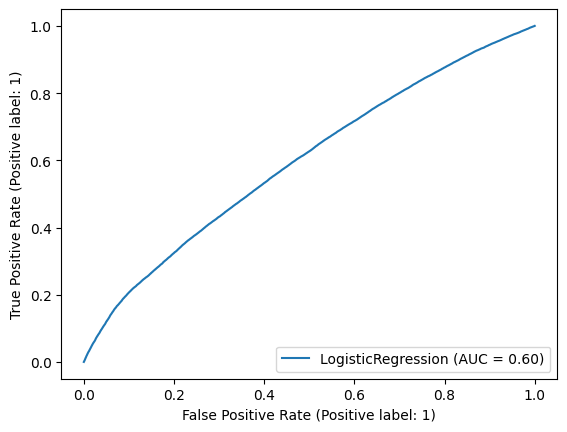

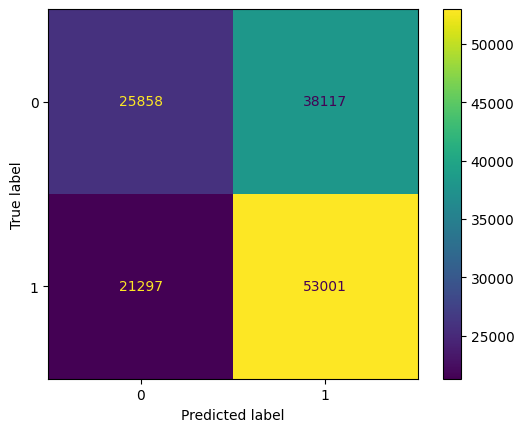

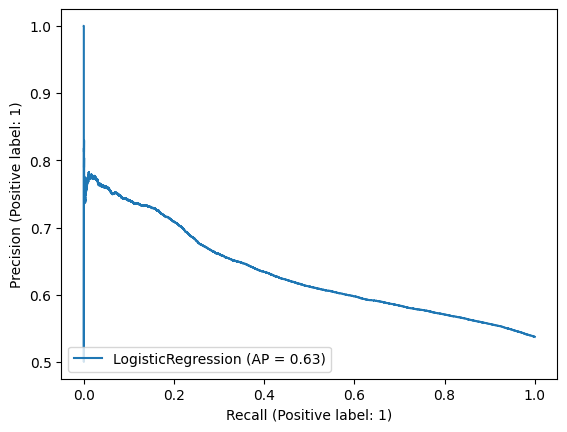

In [72]:
RocCurveDisplay.from_estimator(reg, reg_test.iloc[:, :-1], reg_test["IsCorrect"])
ConfusionMatrixDisplay.from_estimator(reg, reg_test.iloc[:, :-1], reg_test["IsCorrect"])
PrecisionRecallDisplay.from_estimator(reg, reg_test.iloc[:, :-1], reg_test["IsCorrect"])

## Other Supervised Learning Models

In [64]:
perceptron = Perceptron(n_jobs=6)
perceptron.fit(X=reg_train.iloc[:, :-1], y=reg_train["IsCorrect"])

Perceptron(n_jobs=6)

In [66]:
print(perceptron.score(reg_test.iloc[:, :-1], reg_test["IsCorrect"]))

0.47190702450948485


In [74]:
svc = LinearSVC(dual=False)
svc.fit(X=reg_train.iloc[:, :-1], y=reg_train["IsCorrect"])

C:\Users\Bhavana\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.

C:\Users\Bhavana\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



LinearSVC()

In [75]:
print(svc.score(reg_test.iloc[:, :-1], reg_test["IsCorrect"]))

0.5702053184641976


In [80]:
svm = SGDClassifier(n_jobs=6)
svm.fit(X=reg_train.iloc[:, :-1], y=reg_train["IsCorrect"])

SGDClassifier(n_jobs=6)

In [81]:
print(svm.score(reg_test.iloc[:, :-1], reg_test["IsCorrect"]))

0.5640002024979569


## Random Forest Regression

https://towardsdatascience.com/random-forest-regression-5f605132d19d

In [83]:
dtree = DecisionTreeClassifier()
dtree.fit(X=reg_train.iloc[:, :-1], y=reg_train["IsCorrect"])

DecisionTreeClassifier()

In [87]:
print(dtree.score(reg_test.iloc[:, :-1], reg_test["IsCorrect"]))
# plot_tree(dtree)

0.6100250952825208


In [88]:
forest = RandomForestClassifier(n_jobs=6)
forest.fit(X=reg_train.iloc[:, :-1], y=reg_train["IsCorrect"])

RandomForestClassifier(n_jobs=6)

In [89]:
print(forest.score(reg_test.iloc[:, :-1], reg_test["IsCorrect"]))

0.6522893117239085


In [91]:
bagg = BaggingClassifier(n_jobs=6)
bagg.fit(X=reg_train.iloc[:, :-1], y=reg_train["IsCorrect"])

BaggingClassifier()

In [92]:
print(bagg.score(reg_test.iloc[:, :-1], reg_test["IsCorrect"]))

0.6450283135536222


In [95]:
hgb = HistGradientBoostingClassifier()
hgb.fit(X=reg_train.iloc[:, :-1], y=reg_train["IsCorrect"])

HistGradientBoostingClassifier()

In [96]:
print(hgb.score(reg_test.iloc[:, :-1], reg_test["IsCorrect"]))

0.6610835087110282


## PCA

Use FAMD to decompose categoricals into numerical values

* Using FAMD [link](https://towardsdatascience.com/famd-how-to-generalize-pca-to-categorical-and-numerical-data-2ddbeb2b9210)
* 